In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

/home/philippotn/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
userPath = '/home/philippotn'
dataPath = userPath+'/Documents/NO_SAVE/'
    
ds_DFLAT = xr.open_dataset(dataPath+'DFLAT'+'_'+'M100m'+'_mean.nc')
ds_DF500 = xr.open_dataset(dataPath+'DF500'+'_'+'M100m'+'_mean.nc')
#ds_DF500 = xr.open_dataset(dataPath+'DFLAT'+'_'+'M100m'+'_mean2.nc')
dss = [ds_DFLAT,ds_DF500]

colors = ['tab:blue','tab:orange','tab:red','tab:cyan','tab:green']

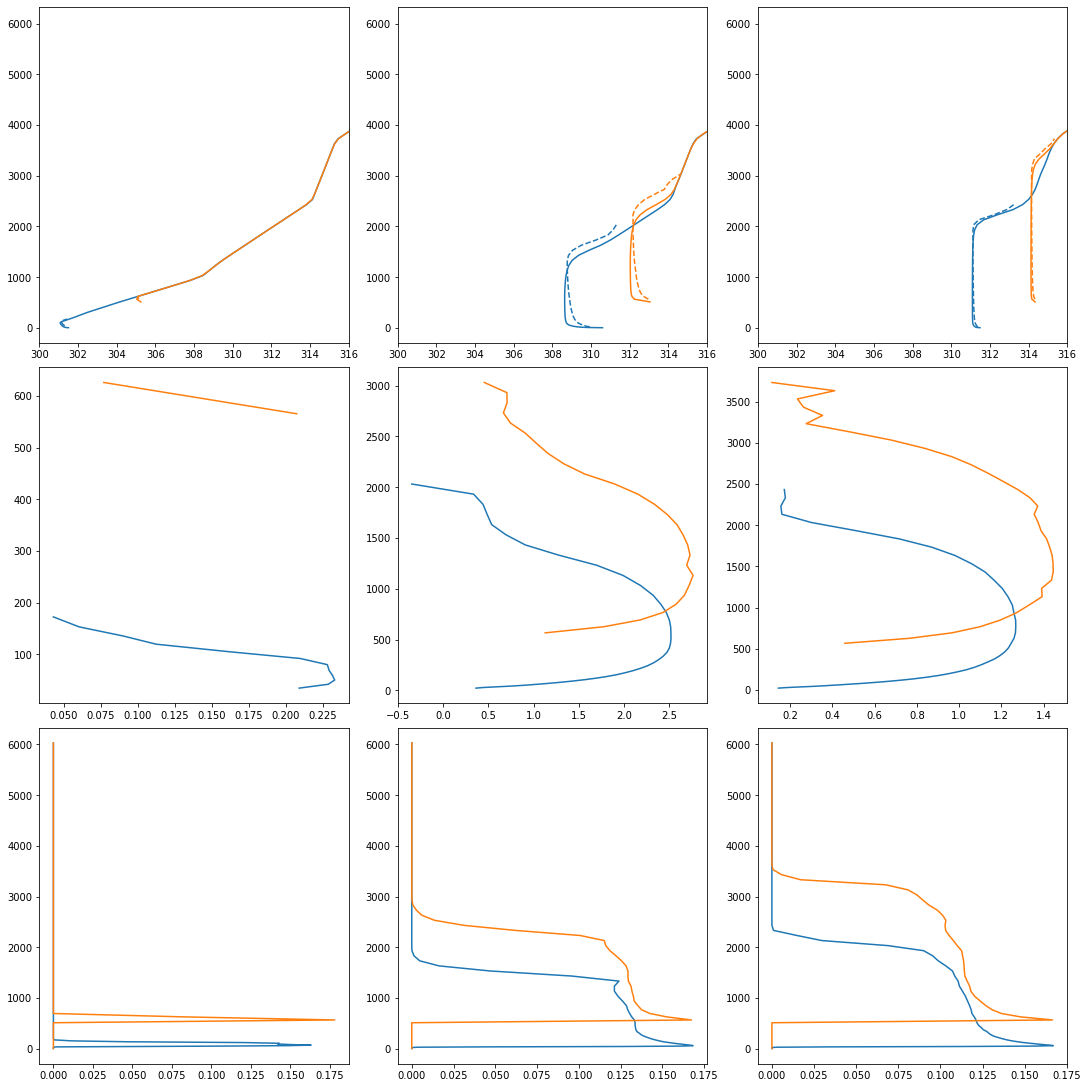

In [4]:
its = [0,6,12]
ncols,nrows = len(its),3
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(5*ncols,5*nrows),constrained_layout=True)
for i,it in enumerate(its):
    for ids,ds in enumerate(dss):
        #RHO = ds_DFLAT['RHO'].data
        #TH = ds['TH_t'].data
        #TH = ds['TKE'].data
        #TH = ds['W_t'].data * ds['ALPHA_t'].data * ds['RHO_t'].data
        z = ds['z'].data
        axs[0,i].set_xlim([300,316])
        axs[0,i].plot(ds['TH'].data[it],z,color=colors[ids])
        axs[0,i].plot(ds['TH_t'].data[it],z,color=colors[ids],linestyle='--')
        
        axs[1,i].plot(ds['W_t'].data[it],z,color=colors[ids])
        axs[2,i].plot(ds['ALPHA_t'].data[it],z,color=colors[ids])
    #axs[1,0].plot(dss[1]['TH'].data[it]-dss[0]['TH'].data[it],z)

In [5]:
g = 9.8 # m/s^2
L = 100e3 # m
ustar = 0.1 # m/s
Kmin = 2. # m^2/s
dzmax = 100 # m
#Kmin = ustar*dzmax**2 /L/8
print(Kmin)
from numba import njit
@njit
def compute_u_msc(dxTH, u_t, f_t, K, rho, TH, z, dz ):
    n = len(z) # all the entries have the same length n # they are defined on mass points
    dxp = np.zeros(n+1)
    sum_dxp = np.zeros(n)
    U = np.zeros(n+1)
    u = np.zeros(n)
    
    for i in range(n-1,-1,-1):
        dxp[i] = dxp[i+1] + dz[i] * g*rho[i]*dxTH[i]/TH[i]
    for j in range(n-2,-1,-1):
        sum_dxp[j] = sum_dxp[j+1] + (z[j+1]-z[j]) * dxp[j+1]
    
    massflux = 0.
    for i in range(n):
        #rhoK_dz = rho[i]*K[i]/dz[i]
        rhoK_dz = rho[i]*max(K[i],Kmin)/dz[i]
        # equation de base sans sur-pression dynamique
        U[i+1] = ( (rhoK_dz-f_t[i]/2)*U[i] + f_t[i]*u_t[i] + sum_dxp[i]  )/(rhoK_dz+f_t[i]/2)
        # equation avec sur pression
        #rhdzus_L = rho[i]*dz[i]*ustar/L
        #U[i+1] = ( (rhoK_dz-f_t[i]/2+3/8*rhdzus_L)*U[i] + f_t[i]*u_t[i] + sum_dxp[i] + ustar/L*massflux )/(rhoK_dz+f_t[i]/2-rhdzus_L/8)
        
        u[i] = (U[i+1]+U[i])/2
        massflux += rho[i]*u[i]*dz[i]
        if abs(u[i])>30 or massflux>1e5:
            u[i]=0.
            break
        
    return u, (dxp[:-1]+dxp[1:])/2      

2.0


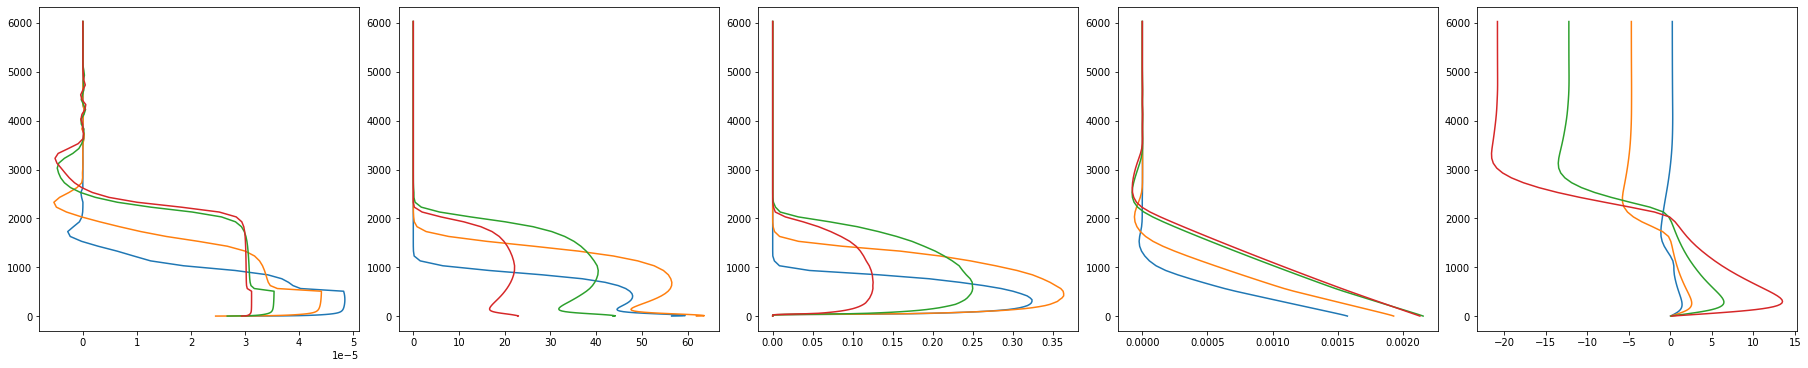

In [6]:
its = [4,6,10,13]
ncols,nrows = 5,1
fig,axs = plt.subplots(ncols=ncols,nrows=nrows,figsize=(5*ncols,5*nrows),constrained_layout=True)
for ii,it in enumerate(its):
    TH_high = ds_DF500['TH'].data[it]
    TH_high[:27] = ds_DF500['TH'].data[it,27]
    dxTH = (TH_high - ds_DFLAT['TH'].data[it]) / L

    z,dz = ds_DFLAT['z'].data, ds_DFLAT['dz'].data
    rho,TH = ds_DFLAT['RHO'].data[it], ds_DFLAT['TH'].data[it]
    K = dz[-1] * np.sqrt( ds_DFLAT['TKE'].data[it] )
    #K = dz[-1] * np.sqrt( ds_DF500['TKE'].data[it] )
    f_t = ds_DFLAT['W_t'].data[it] * ds_DFLAT['ALPHA_t'].data[it] * ds_DFLAT['RHO_t'].data[it]
    f_t[np.isnan(f_t)] = 0.
    u_t = np.zeros(len(z))
    
    i=0
    u,dxp = compute_u_msc(dxTH, u_t, f_t, K, rho, TH, z, dz )
    axs[0].plot(dxTH,z)
    axs[1].plot(K,z)
    axs[2].plot(f_t,z)
    axs[3].plot(dxp,z)
    axs[4].plot(u,z)